# High Frequency Trading

In [1]:
import pymapd
import ibis
import altair as alt
import jupyterlab_omnisci

In [2]:
alt.renderers.enable('ibis')
alt.data_transformers.enable('ibis')

DataTransformerRegistry.enable('ibis')

In [3]:
user = "mapd"
password = "HyperInteractive"
db = "mapd"
port = 7274
protocol = "binary"
host="localhost"

In [4]:
con_pymapd = pymapd.connect(user=user,
                password=password,
                host=host,
                dbname=db,
                port=port,
                protocol=protocol)

In [5]:
con_pymapd.get_table_details("chelsea")

[ColumnDetails(name='a', type='TIMESTAMP', nullable=True, precision=0, scale=0, comp_param=0, encoding='NONE'),
 ColumnDetails(name='b', type='TIMESTAMP', nullable=True, precision=3, scale=0, comp_param=0, encoding='NONE'),
 ColumnDetails(name='c', type='TIMESTAMP', nullable=True, precision=6, scale=0, comp_param=0, encoding='NONE'),
 ColumnDetails(name='d', type='TIMESTAMP', nullable=True, precision=9, scale=0, comp_param=0, encoding='NONE')]

In [6]:
con_ibis = ibis.mapd.connect(user=user,
                password=password,
                host=host,
                database=db,
                port=port,
                protocol=protocol)

In [7]:
st = con_ibis.table('msft_stocks')

In [8]:
count_ = st.count()
print(count_.compile())
count_.execute()

SELECT count(*) AS "count"
FROM msft_stocks


12096000

In [9]:
data = st[st.timestamp_, st.price_]
print(data.compile())

SELECT "timestamp_", "price_"
FROM msft_stocks


In [10]:
df_sample = data.execute(limit=10)
df_sample

,timestamp_,price_
0,2019-04-01 14:17:29.800,118.985719
1,2019-04-01 14:17:29.900,118.951939
2,2019-04-01 14:06:49.800,118.677439
3,2019-04-01 14:09:29.800,118.827116
4,2019-04-01 14:17:30.000,118.959386
5,2019-04-01 14:20:00.200,118.569264
6,2019-04-01 14:06:49.900,118.627863
7,2019-04-01 14:09:29.900,118.692718
8,2019-04-01 13:46:21.000,118.783697
9,2019-04-01 14:20:00.300,118.125336


In [11]:
expr = st[st.timestamp_.cast('DATE').name('date_'), 
          st.price_].groupby('date_').aggregate(avg_price = st.price_.mean())
print(expr.compile())
# df = expr.execute()
# df

SELECT "date_", avg("price_") AS avg_price
FROM (
  SELECT CAST("timestamp_" AS DATE) AS date_, "price_"
  FROM msft_stocks
) t0
GROUP BY date_


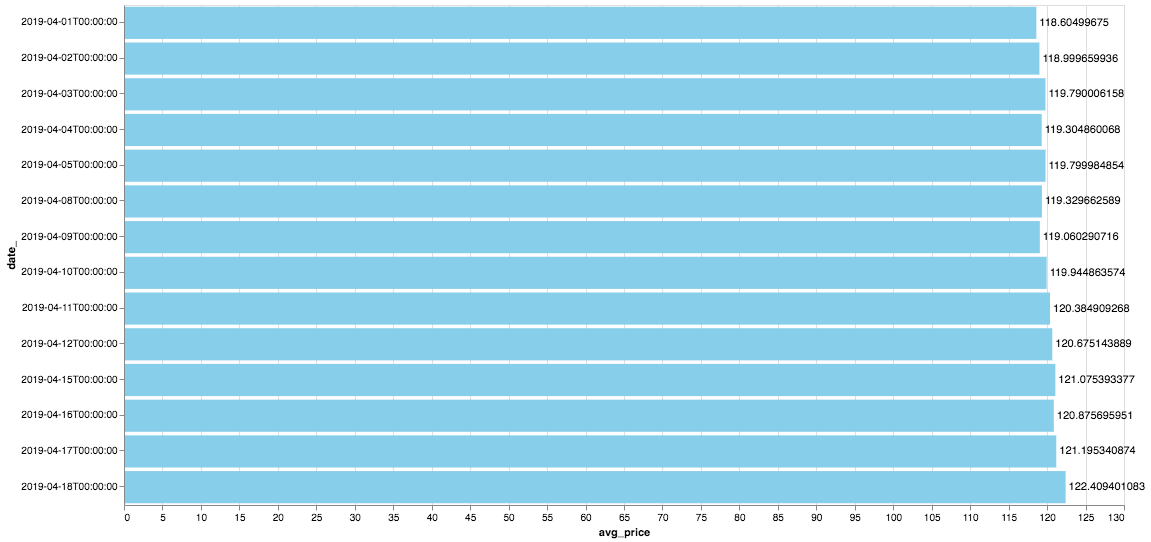

In [12]:
bar = alt.Chart(expr).mark_bar(color='skyblue').encode(
        alt.Y('date_:O'),
        alt.X('avg_price:Q')
        )
text = bar.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='avg_price:Q'
)
org = bar+text
(org).properties(height=500, width=1000)

In [15]:
range_ = st[st.timestamp_.between('2019-04-01 09:00:00.000', '2019-04-01 9:00:05.999')]
print(range_.compile())
# df_range = range_.execute()
# df_range

SELECT *
FROM msft_stocks
WHERE "timestamp_" BETWEEN '2019-04-01 09:00:00.000' AND '2019-04-01 9:00:05.999'


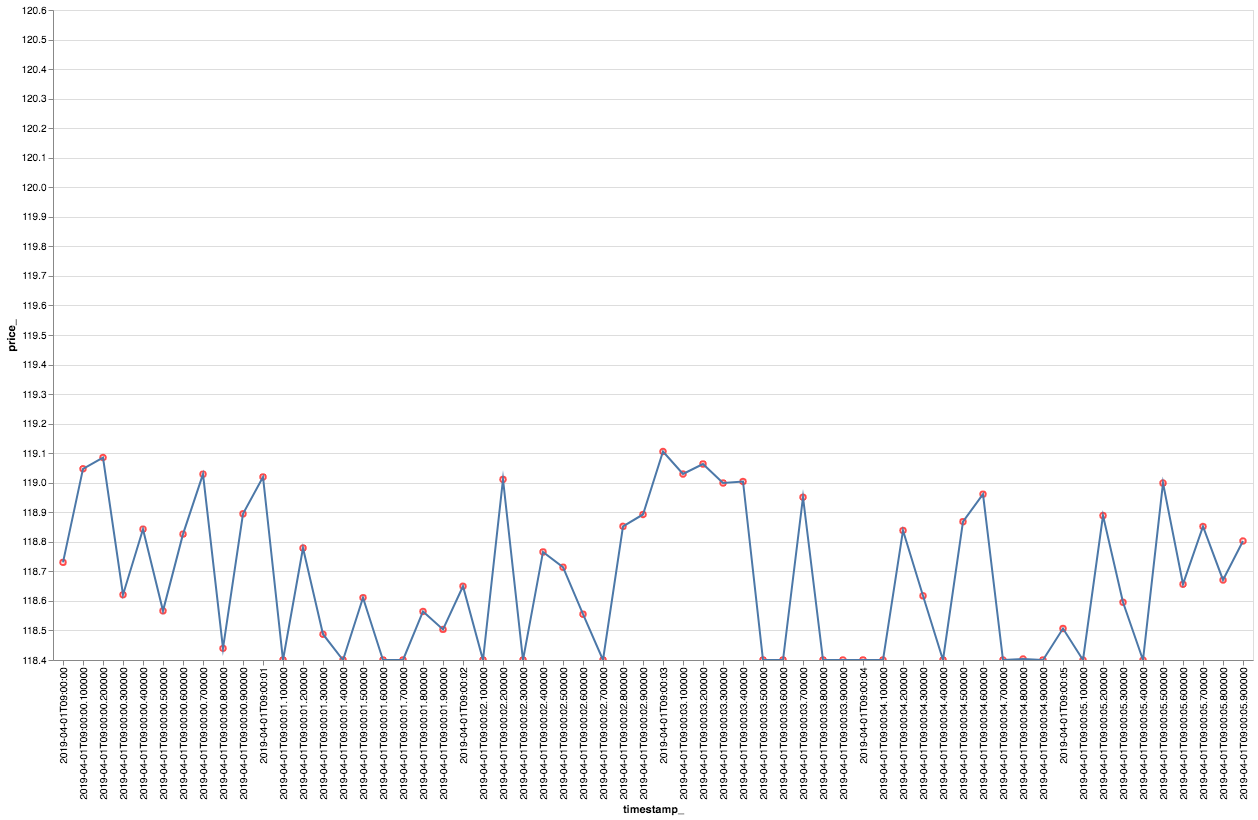

In [17]:
htf = alt.Chart(range_).encode(
        alt.X('timestamp_:O'),
        alt.Y('price_:Q',
             scale=alt.Scale(domain=(118.5,120.5), clamp=True))).properties(height=650, width= 1200)

alt.layer(htf.mark_point(color='red') + htf.mark_line()).interactive()

In [18]:
import requests, json
headers = {"Content-type": "application/json"}
conditions_ = "timestamp_ between '2019-04-01 00:00:00' and '2019-04-12 23:59:59.999'"
query_ = "cast(timestamp_ as date) , avg(price_),msft_stocks, False, {} , True, None, None, additive, 6, D".format(conditions_)
requests.post("http://localhost:1337/forecast/predict", headers=headers, data=json.dumps({"input": query_})).json()

{'query_id': 0, 'output': '202, msft_stocks_forecast', 'default': False}

In [19]:
nt = con_ibis.table('msft_stocks_forecast')
expr1 = nt[nt.ds.name('date_'), nt.yhat.name("price_")]

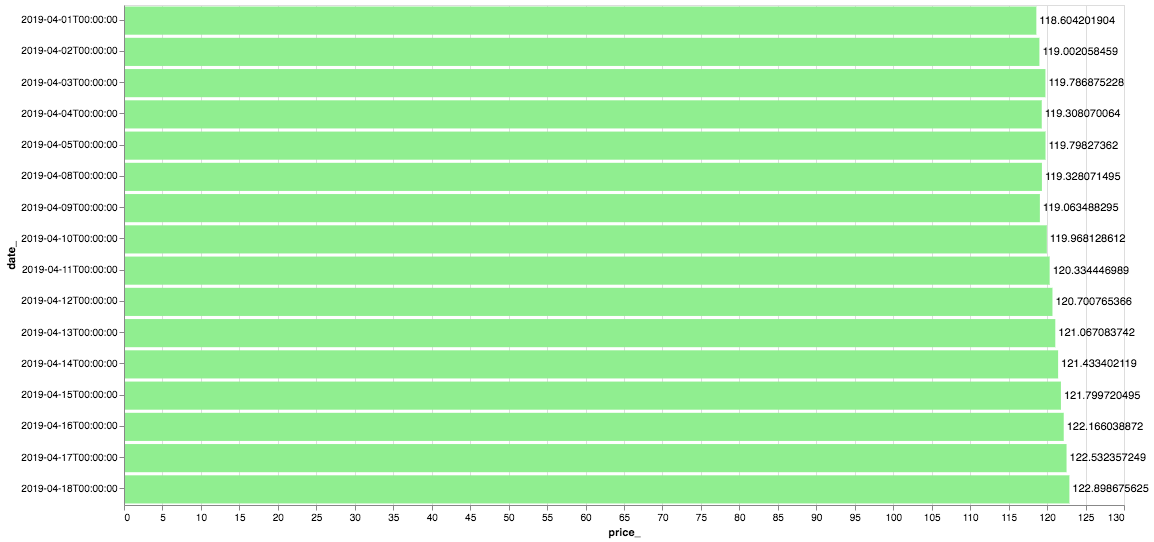

In [20]:
bar2 = alt.Chart(expr1).mark_bar(color='lightgreen').encode(
        alt.Y('date_:O'),
        alt.X('price_:Q')
        )
text = bar2.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='price_:Q'
)
pred = bar2+text
(pred).properties(height=500, width=1000)

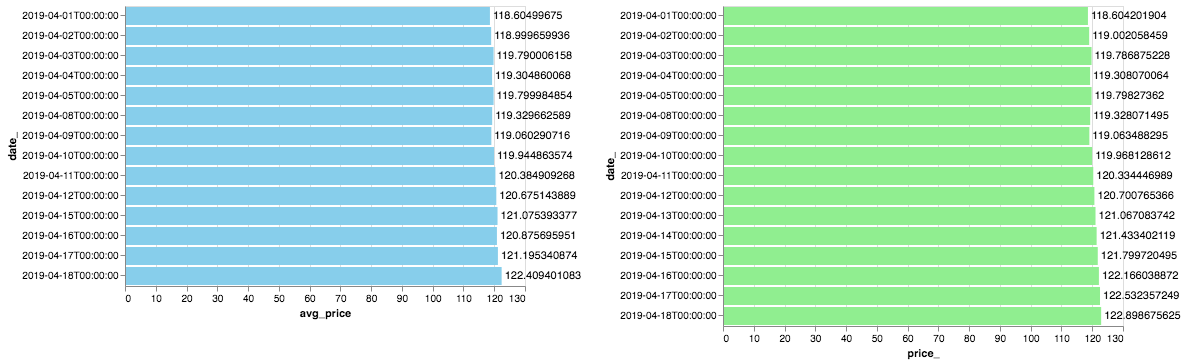

In [21]:
org | pred